In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
from transformers import AutoTokenizer
import string
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model



In [2]:
uploaded = files.upload()

file_name=next(iter(uploaded))
df=pd.read_csv("hate_data.csv")
df.head()  # Display the first few rows of the dataframe


Saving hate_data.csv to hate_data.csv


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


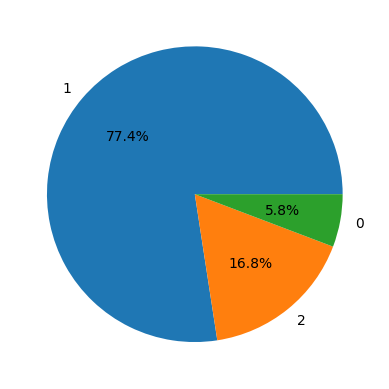

In [3]:
plt.pie(df['class'].value_counts().values,labels = df['class'].value_counts().index,autopct='%1.1f%%')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


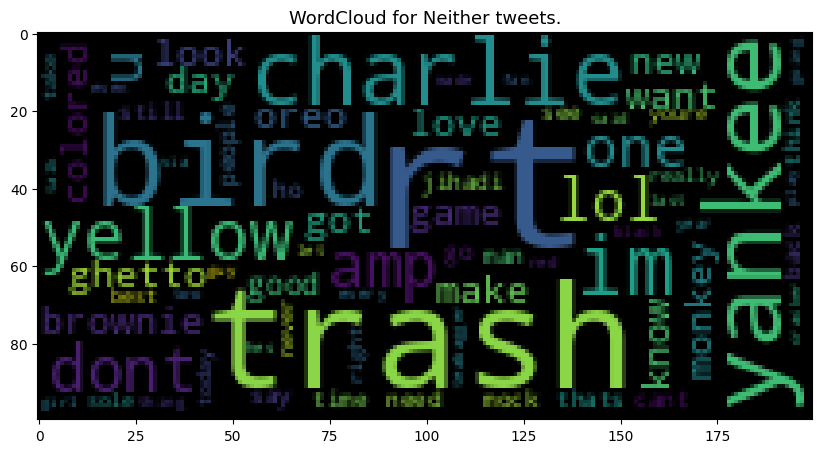

In [4]:
nltk.download('stopwords')
def clean_tweets(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    stop_words = set(stopwords.words('english'))#list of stopwords
    text = ' '.join([word for word in text.lower().split() if word not in stop_words])
    return text
df['tweet'] = df['tweet'].apply(clean_tweets)

def remove_integers(value):
    if isinstance(value, str):
        return re.sub(r'\d+', '', value).strip()
    return value
df["tweet"] = df["tweet"].apply(remove_integers)
df.to_csv("hate_data_cleaned.csv", index=False)
# print(df.head())

#visualize most frequents words
df_=pd.read_csv("hate_data_cleaned.csv")
def plot_word_cloud(data, typ):
  email_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))
  wc = WordCloud(max_words = 500,width = 200,height = 100,collocations = False).generate(email_corpus)

  plt.title(f'WordCloud for {typ} tweets.', fontsize = 13)
  plt.imshow(wc)
plt.show()
print()

plot_word_cloud(df_[df_['class']==2], typ='Neither')

In [11]:
feature=df_["tweet"]
target=df_["class"]
X_train,X_val,Y_train,Y_val=train_test_split(feature,target,test_size=0.2,random_state=22)
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

In [12]:
# Filter classes
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500, random_state=42)  # Downsample class 1
class_0 = df[df['class'] == 0]

class_0_upsampled = pd.concat([class_0] * 3, axis=0)
balanced_df = pd.concat([class_0_upsampled, class_1, class_2], axis=0)


In [13]:
max_words = 500
max_len = 100

token = Tokenizer(num_words=max_words,lower=True,split=' ')
token.fit_on_texts(X_train)

In [14]:
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,maxlen=100,padding='post',truncating='post')

Testing_seq = token.texts_to_sequences(X_val)
Testing_pad = pad_sequences(Testing_seq,maxlen=100,padding='post',truncating='post')

In [15]:
model = keras.models.Sequential([layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(32)),layers.Dense(512, activation='relu', kernel_regularizer='l2'),layers.BatchNormalization(),layers.Dropout(0.5),layers.Dense(3, activation='softmax')])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.build(input_shape=(None, max_len))
print(model.summary())



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,507 (271.51 KB)

 Trainable params: 68,483 (267.51 KB)

 Non-trainable params: 1,024 (4.00 KB)

None


In [16]:
model.build((None, max_len))
# keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_activations=True)

In [17]:
early_stop = EarlyStopping(patience=3,monitor = 'val_accuracy',restore_best_weights = True)#training stops when acc does not improve for 3 consecutive epochs
lear_rate = ReduceLROnPlateau(patience = 3,monitor = 'val_loss',factor = 0.1,verbose = 2)

In [18]:
tokenizer = Tokenizer(num_words=max_words)

# Fit on training data
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_val_padded = pad_sequences(X_val_seq,maxlen=max_len)
history = model.fit(X_train_padded, Y_train,validation_data=(X_val_padded, Y_val),epochs=50,verbose=2,batch_size=32,callbacks=[lear_rate, early_stop])

Epoch 1/50
620/620 - 51s - 83ms/step - accuracy: 0.8638 - loss: 0.4745 - val_accuracy: 0.7847 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 2/50
620/620 - 79s - 127ms/step - accuracy: 0.8850 - loss: 0.3181 - val_accuracy: 0.8626 - val_loss: 0.3404 - learning_rate: 0.0010
Epoch 3/50
620/620 - 84s - 136ms/step - accuracy: 0.8903 - loss: 0.3054 - val_accuracy: 0.8937 - val_loss: 0.3046 - learning_rate: 0.0010
Epoch 4/50
620/620 - 83s - 134ms/step - accuracy: 0.8912 - loss: 0.2999 - val_accuracy: 0.8866 - val_loss: 0.3077 - learning_rate: 0.0010
Epoch 5/50
620/620 - 79s - 128ms/step - accuracy: 0.8953 - loss: 0.2877 - val_accuracy: 0.8903 - val_loss: 0.3248 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
620/620 - 83s - 133ms/step - accuracy: 0.8969 - loss: 0.2825 - val_accuracy: 0.8836 - val_loss: 0.3150 - learning_rate: 0.0010


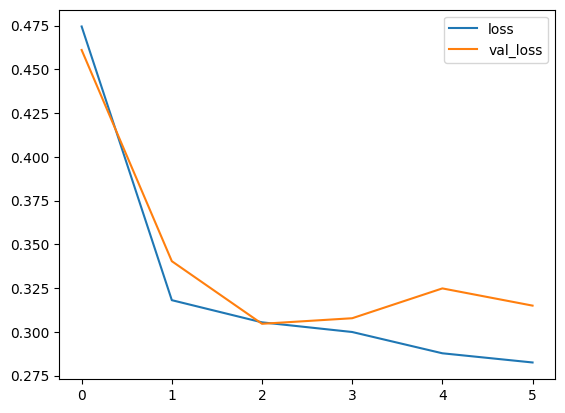

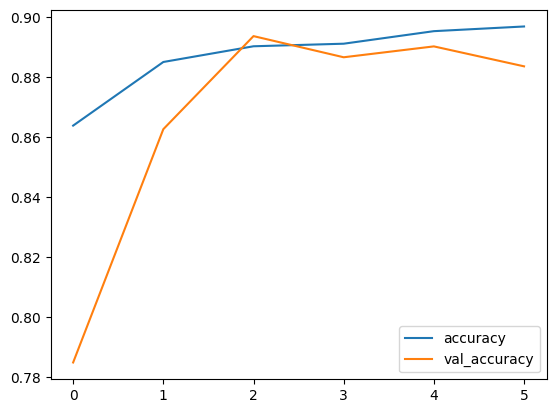

In [19]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()